In [ ]:
from datasets import load_dataset

num_samples_to_take = 100
ds = load_dataset("sayeed99/fashion_segmentation", split="train",streaming=True)
ds = ds.take(num_samples_to_take)

In [8]:
ds

IterableDataset({
    features: ['image', 'label'],
    num_shards: 53
})

In [31]:
unique_labels = set()

for sample in ds:
    mask = sample['label']
    unique_labels.update(np.unique(mask))

total_unique_labels = len(unique_labels)
print("Total number of unique labels in the masks:", total_unique_labels)


Total number of unique labels in the masks: 31


In [9]:
sample = next(iter(ds))
sample['image'] , sample['label']

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3676x5214>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=3676x5214>)

Text(0.5, 1.0, 'Segmentation Label')

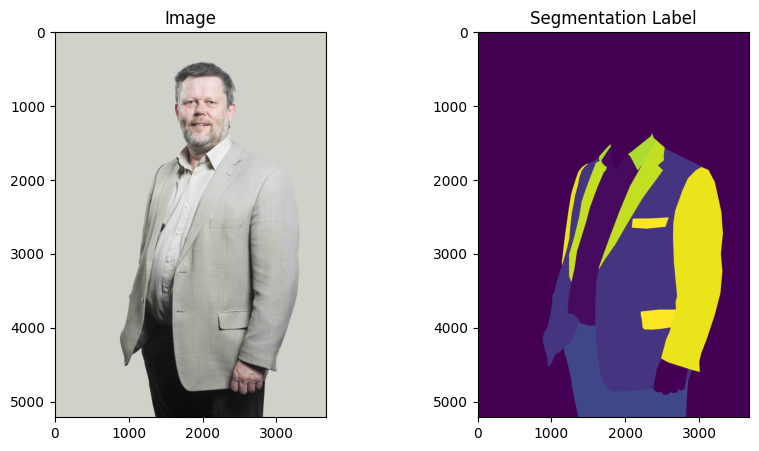

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample['image'])
ax[0].set_title('Image')    
ax[1].imshow(sample['label'])   
ax[1].set_title('Segmentation Label')

In [6]:
import random
import numpy as np

def plot_random_sample(dataset):
    skip_n = random.randint(0, num_samples_to_take - 1)
    sample = next(iter(dataset.skip(skip_n)))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(sample['image'])
    ax[0].set_title('Image')    
    ax[1].imshow(sample['label'])   
    ax[1].set_title('Segmentation Label')
    print(np.unique(np.array(sample['label'])))
    plt.show()


[ 0 11 24 34]


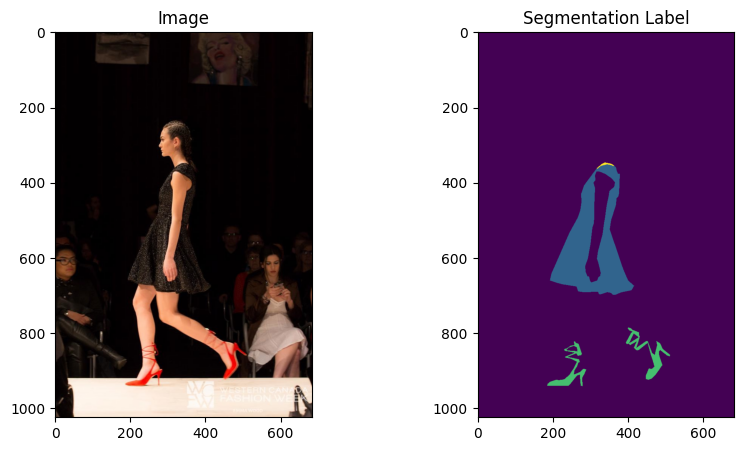

In [11]:
plot_random_sample(ds)

[ 0 11 19 25 34 45]


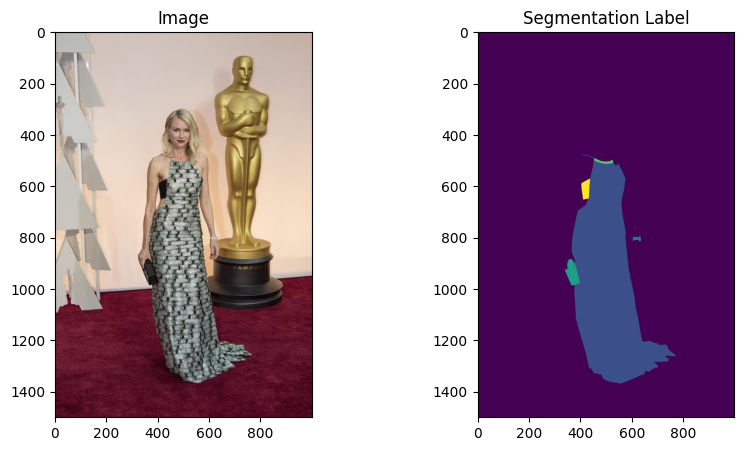

In [7]:
plot_random_sample(ds)

Class 1: 847796 pixels
Class 5: 2817303 pixels
Class 7: 883261 pixels
Class 29: 90310 pixels
Class 30: 494904 pixels
Class 32: 1566584 pixels
Class 33: 169658 pixels


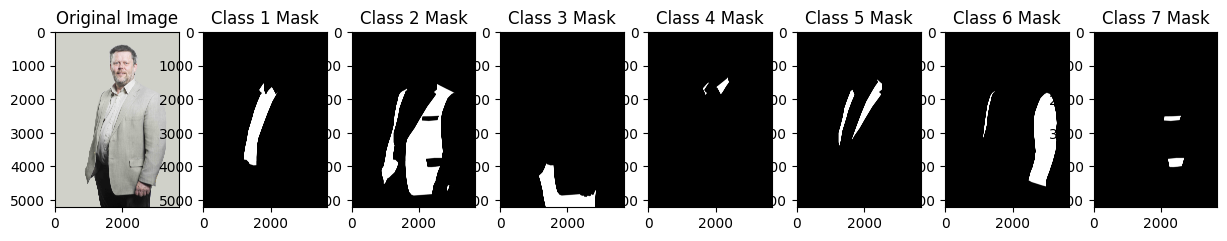

In [17]:
def extract_class_mask(mask):
    mask = np.array(mask)
    class_ids = np.unique(mask)
    
    class_ids = class_ids[class_ids != 0]

    binary_masks = []
    for class_id in class_ids:
        binary_mask = (mask == class_id).astype(np.uint8)
        binary_masks.append(binary_mask)
        print(f"Class {class_id}: {np.sum(binary_mask)} pixels")

    return binary_masks

sample = next(iter(ds))
mask = sample["label"]

binary_masks = extract_class_mask(mask)
fig, axes = plt.subplots(1, len(binary_masks)+1, figsize=(15, 5))
axes[0].imshow(sample["image"])
axes[0].set_title("Original Image")

for i, bm in enumerate(binary_masks):
    axes[i+1].imshow(bm, cmap="gray")
    axes[i+1].set_title(f"Class {i+1} Mask")

plt.show()

Class 1 point prompt: (1755, 2034)


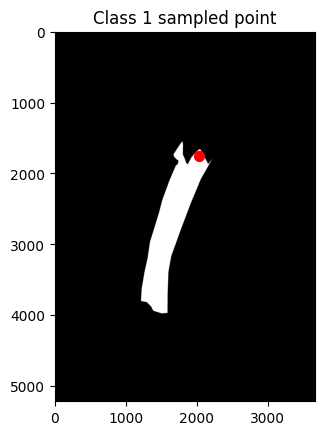

Class 2 point prompt: (2114, 2389)


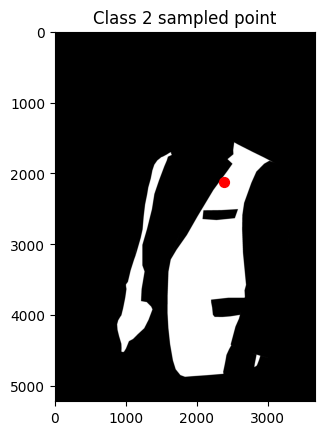

Class 3 point prompt: (4943, 1335)


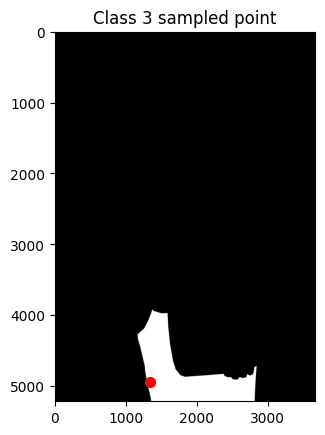

Class 4 point prompt: (1552, 1795)


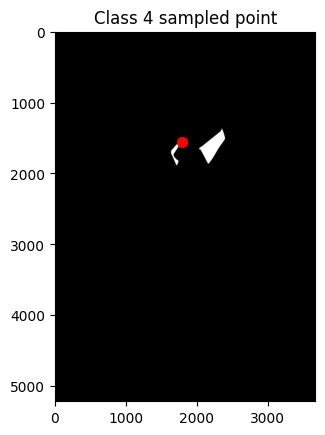

Class 5 point prompt: (2083, 1495)


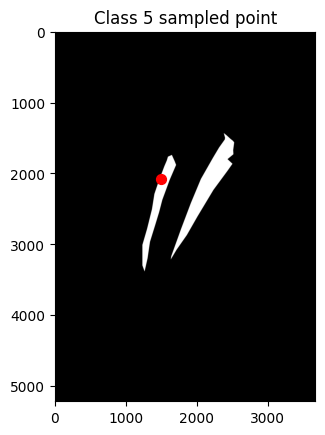

Class 6 point prompt: (4505, 2757)


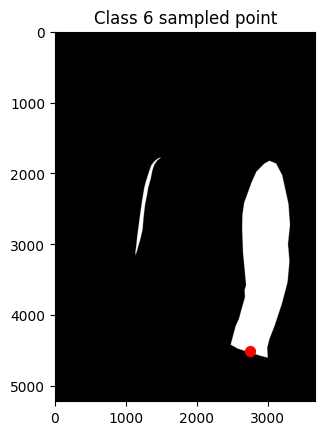

Class 7 point prompt: (2646, 2365)


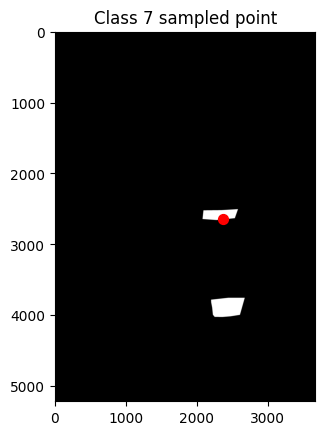

In [18]:
def sample_point_from_mask(binary_mask):
    ys, xs = np.where(binary_mask == 1)
    if len(xs) == 0:
        return None  # no foreground pixels found
    
    idx = random.randint(0, len(xs) - 1)
    y, x = ys[idx], xs[idx]
    return (y, x)

for i, mask in enumerate(binary_masks):
    point = sample_point_from_mask(mask)
    print(f"Class {i+1} point prompt:", point)

    if point is not None:
        plt.imshow(mask, cmap="gray")
        plt.scatter(point[1], point[0], c="red", s=50)
        plt.title(f"Class {i+1} sampled point")
        plt.show()

In [13]:
def extract_class_masks(mask):
    mask = np.array(mask)
    class_ids = np.unique(mask)
    class_ids = class_ids[class_ids != 0]  # exclude background
    binary_masks = [(mask == cid).astype(np.uint8) for cid in class_ids]
    return binary_masks, class_ids

def visualize_point_and_mask(sample):
    image = np.array(sample["image"])
    mask = np.array(sample["label"])
    
    binary_masks, class_ids = extract_class_masks(mask)
    
    idx = random.randint(0, len(binary_masks) - 1)
    binary_mask = binary_masks[idx]
    class_id = class_ids[idx]
    
    point = sample_point_from_mask(binary_mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image)
    if point is not None:
        axes[1].scatter(point[1], point[0], c='red', s=60, marker='*', edgecolors='white')
    axes[1].set_title(f"Sampled Point (Class {class_id})")
    axes[1].axis("off")
    
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f"Binary Mask for Class {class_id}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

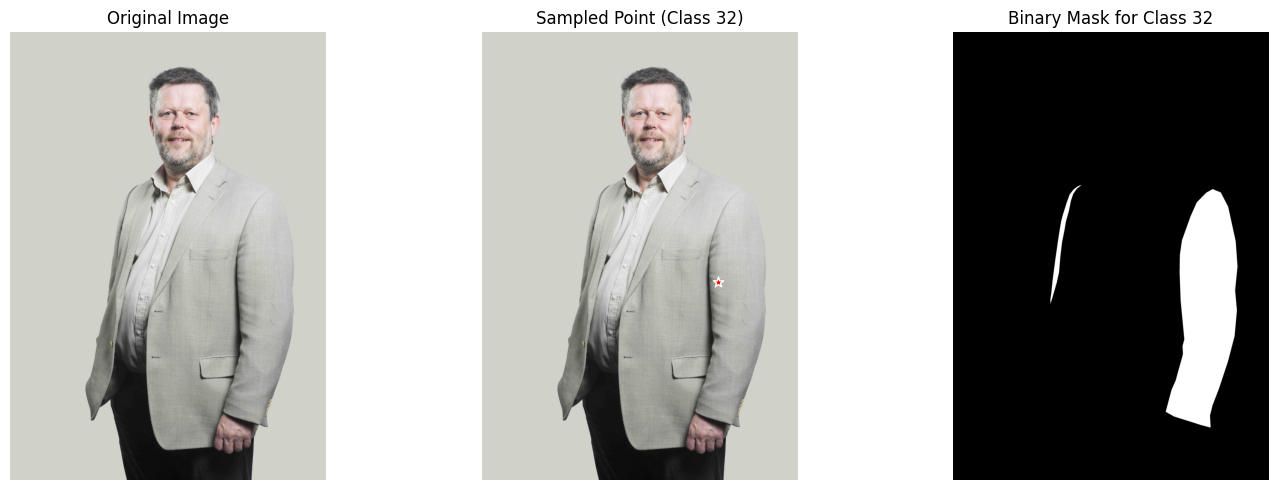

In [19]:
sample = next(iter(ds))
visualize_point_and_mask(sample)

### Convert dataset to SAM format

In [2]:
from tqdm import tqdm

In [14]:
def prepare_sam_training_data(dataset, max_samples=100):
    processed_data = []

    for i, sample in enumerate(tqdm(dataset, total=max_samples, desc="Preparing data")):
        if i >= max_samples:
            break

        image = np.array(sample["image"])
        mask = np.array(sample["label"])

        binary_masks, class_ids = extract_class_masks(mask)

        for class_id, binary_mask in zip(class_ids, binary_masks):
            point = sample_point_from_mask(binary_mask)
            if point is None:
                continue

            processed_data.append({
                "image": image,
                "mask": binary_mask,
                "point": point,
                "class_id": int(class_id)
            })

    return processed_data


In [19]:
num_samples_to_take = 50
ds = load_dataset("sayeed99/fashion_segmentation", split="train", streaming=True)
ds = ds.take(num_samples_to_take)

sam_data = prepare_sam_training_data(ds, max_samples=num_samples_to_take)
print(f"Prepared {len(sam_data)} training samples")

Preparing data: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]

Prepared 250 training samples


In [24]:
import os
import csv
from PIL import Image
import numpy as np
import pandas as pd

In [ ]:
print("cwd:", os.getcwd()) 

In [ ]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "fashion_sam_dataset_v1")
print("data_dir:", data_dir)

In [ ]:
assert os.path.isdir(data_dir), f"data_dir not found: {data_dir}"
print("listing top-level:", os.listdir(data_dir)[:10])
csv_path = os.path.join(data_dir, "train.csv")
assert os.path.exists(csv_path), f"train.csv not found at {csv_path}"

In [ ]:
df = pd.read_csv(csv_path)
print("rows in CSV:", len(df))
# Check first image and mask exist
first_img = os.path.join(data_dir, "images", df.iloc[0]["imageid"])
first_mask = os.path.join(data_dir, "masks", df.iloc[0]["maskid"])
print("first image exists:", os.path.exists(first_img))
print("first mask exists:", os.path.exists(first_mask))

In [99]:
image_paths = [os.path.join(data_dir, "images", img) for img in df["imageid"]]
mask_paths  = [os.path.join(data_dir, "masks", msk) for msk in df["maskid"]]

In [100]:
missing_imgs = [p for p in image_paths if not os.path.exists(p)]
missing_masks = [p for p in mask_paths if not os.path.exists(p)]
if missing_imgs or missing_masks:
    raise FileNotFoundError(f"Missing images: {len(missing_imgs)}, masks: {len(missing_masks)}")

In [101]:
def create_dataset(image_paths, label_paths):
    ds = Dataset.from_dict({"image": sorted(image_paths), "label": sorted(label_paths)})
    ds = ds.cast_column("image", Image())
    ds = ds.cast_column("label", Image())
    return ds

train_dataset = create_dataset(image_paths, mask_paths)
dataset_dict = DatasetDict({"train": train_dataset})

In [ ]:
REPO = "peaceAsh/fashion-sam-dataset"  
dataset_dict.push_to_hub(REPO,token="<fill-token>")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  4.84ba/s]
Processing Files (1 / 1): 100%|██████████| 68.0MB / 68.0MB,  583kB/s  
New Data Upload: 100%|██████████| 2.33MB / 2.33MB,  583kB/s  
Uploading the dataset shards: 100%|██████████| 1/1 [00:07<00:00,  7.05s/ shards]


CommitInfo(commit_url='https://huggingface.co/datasets/peaceAsh/fashion-sam-dataset/commit/9d0985b8e1bb2c8df0ad428ab16c6bf8b7b27751', commit_message='Upload dataset', commit_description='', oid='9d0985b8e1bb2c8df0ad428ab16c6bf8b7b27751', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/peaceAsh/fashion-sam-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='peaceAsh/fashion-sam-dataset'), pr_revision=None, pr_num=None)

In [25]:
def save_sam_dataset(sam_data, output_dir="../fashion_sam_dataset"):
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)

    csv_path = os.path.join(output_dir, "train.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["imageid", "maskid"])

        for idx, sample in enumerate(sam_data):
            image = Image.fromarray(np.uint8(sample["image"]))
            mask = Image.fromarray(np.uint8(sample["mask"]) * 255)  # convert 0/1 → 0/255

            img_filename = f"sample_{idx}.jpg"
            mask_filename = f"mask_sample_{idx}.png"

            image.save(os.path.join(output_dir, "images", img_filename))
            mask.save(os.path.join(output_dir, "masks", mask_filename))

            writer.writerow([img_filename, mask_filename])

    print(f"Dataset saved successfully at: {output_dir}")


In [26]:
save_sam_dataset(sam_data, output_dir="../fashion_sam_dataset")

Dataset saved successfully at: ../fashion_sam_dataset


### Load data from Hub :

In [1]:
REPO = "peaceAsh/fashion-sam-dataset" 

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datasets import load_dataset, DatasetDict, Dataset
from src.utils import viz_sample


/home/ash/Projects/FashionSeg/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_and_split_dataset(repo_id):
    dataset = load_dataset(repo_id)
    train_test_split = dataset["train"].train_test_split(test_size=0.15, seed=42)
    val_test_split = train_test_split["test"].train_test_split(test_size=(2/3), seed=42)

    dataset_dict = DatasetDict({
        "train": train_test_split["train"],
        "validation": val_test_split["train"],
        "test": val_test_split["test"]
    })
    return dataset_dict

In [4]:
ds = load_and_split_dataset(REPO)

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 212
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 12
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 26
    })
})

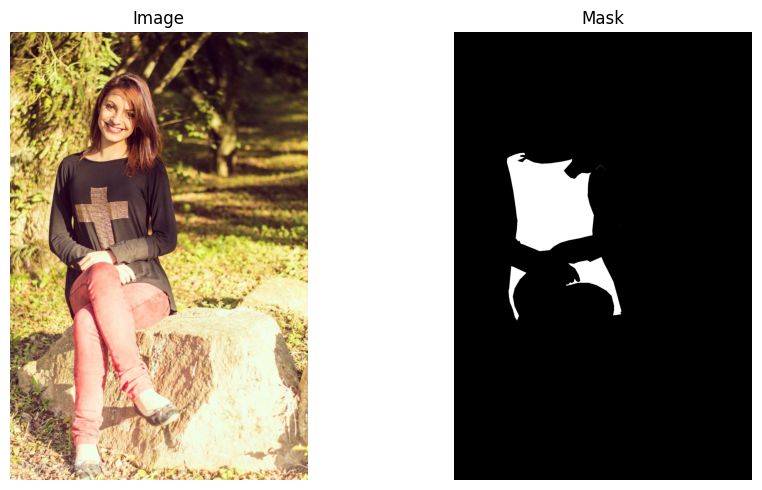

In [6]:
viz_sample(ds["train"],127)

In [22]:
def process_sample_points(sample, target_size=640, points_per_mask=5):
    image_pil = sample['image']
    mask_pil = sample['label']
    
    # Convert to numpy arrays
    image = np.array(image_pil.convert("RGB"))
    mask = np.array(mask_pil.convert("L")) 
    print(f"    Shape: {mask.shape}, dtype: {mask.dtype}")
    print(f"    Unique values: {np.unique(mask)}")
    print(f"    Value range: [{mask.min()}, {mask.max()}]")
    
    
    # 2. Resize maintaining aspect ratio
    h, w = image.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    
    image_resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
    print(f"\n2. After resize:")
    print(f"   Shape: {mask_resized.shape}, dtype: {mask_resized.dtype}")
    print(f"   Unique values: {np.unique(mask_resized)}")
    print(f"   Value range: [{mask_resized.min()}, {mask_resized.max()}]")
    
    
    # 3. Pad to target size
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    
    image_padded = np.pad(image_resized, ((0, pad_h), (0, pad_w), (0, 0)), 
                         mode='constant', constant_values=0)
    mask_padded = np.pad(mask_resized, ((0, pad_h), (0, pad_w)), 
                        mode='constant', constant_values=0)
    print(f"\n3. After pad:")
    print(f"   Shape: {mask_padded.shape}, dtype: {mask_padded.dtype}")
    print(f"   Unique values: {np.unique(mask_padded)}")
    print(f"   Value range: [{mask_padded.min()}, {mask_padded.max()}]")
    
    
    # Create binary mask
    binary_mask = (mask_padded > 0).astype(np.uint8)
    print(f"\n4. After binary conversion:")
    print(f"   Shape: {binary_mask.shape}, dtype: {mask_padded.dtype}")
    print(f"   Unique values: {np.unique(binary_mask)}")
    print(f"   Value range: [{binary_mask.min()}, {binary_mask.max()}]")
    
    
    # 5. Handle empty mask
    if binary_mask.sum() == 0:
        return {
            "image": image_padded,
            "binary_mask": binary_mask,
            "num_masks": 0
        }

    return {
        "image":image_padded,
        "binary_mask": binary_mask,
        "num_masks": 1
    }
    
    
def viz_processed_sample(sample,processed_data):
    og_image = sample["image"]
    resized_image = processed_data["image"]
    binary_mask = processed_data["binary_mask"]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(og_image)
    axes[0].set_title(f"Original Image:{og_image.size}")
    axes[0].axis('off')

    axes[1].imshow(resized_image)
    axes[1].set_title(f"Resized Image:{resized_image.shape}")
    axes[1].axis('off')
    
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f"Binarized Mask:{binary_mask.shape}")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
SAMPLE_INDEX = np.random.randint(len(ds["train"]))
print(f"Sample_index:{SAMPLE_INDEX}")
sample = ds['train'][SAMPLE_INDEX]
processed_data = process_sample_points(sample)

Sample_index:114
    Shape: (4608, 3072), dtype: uint8
    Unique values: [  0 255]
    Value range: [0, 255]

2. After resize:
   Shape: (640, 426), dtype: uint8
   Unique values: [  0 255]
   Value range: [0, 255]

3. After pad:
   Shape: (640, 640), dtype: uint8
   Unique values: [  0 255]
   Value range: [0, 255]

4. After binary conversion:
   Shape: (640, 640), dtype: uint8
   Unique values: [0 1]
   Value range: [0, 1]


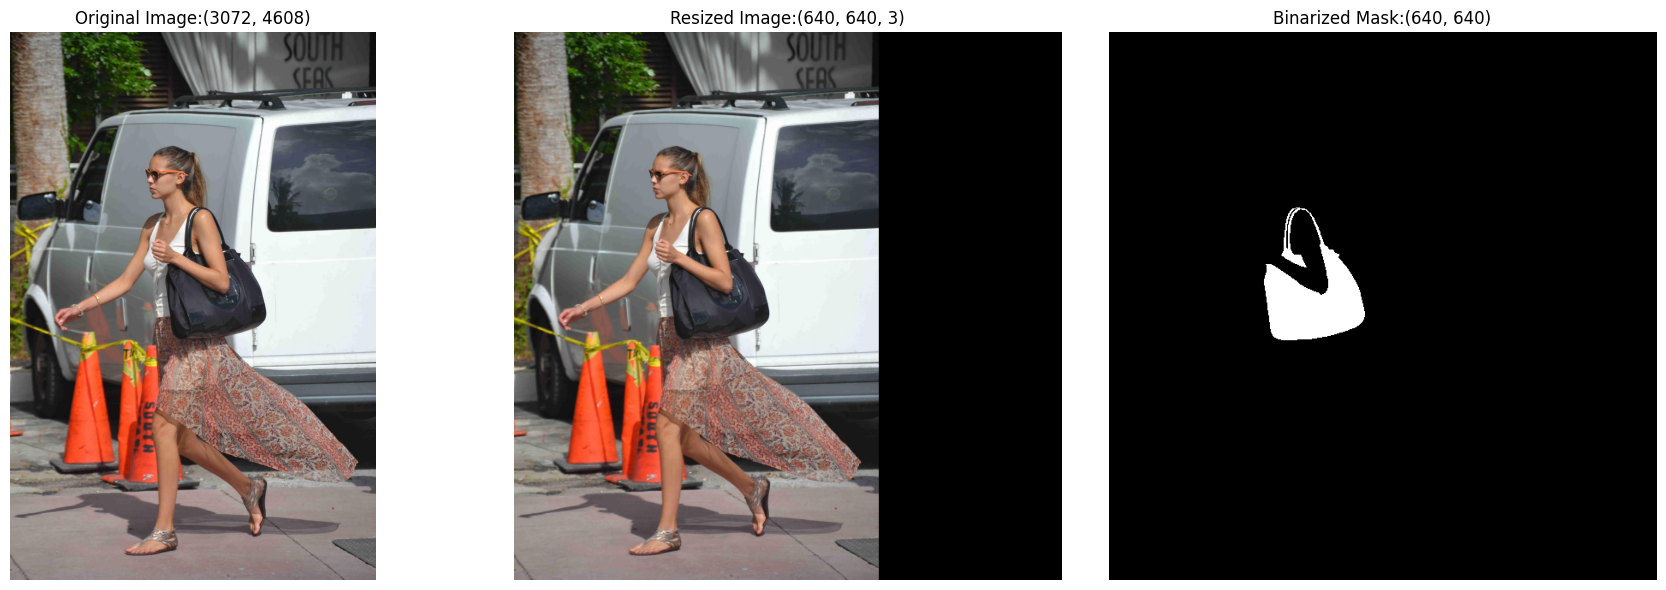

In [28]:
viz_processed_sample(sample,processed_data)

### Load dataset:

In [35]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from datasets import load_dataset
from pycocotools.coco import COCO

In [36]:
HF_REPO_NAME = "peaceAsh/fashion_sam_dataset_v2"

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "fashion_seg_coco")
COCO_ANNOTATION_FILE = os.path.join(data_dir, "result.json")


In [37]:
hf_dataset = load_dataset(HF_REPO_NAME)['train']

Generating train split: 100%|██████████| 15/15 [00:00<00:00, 76.89 examples/s]


In [38]:
coco = COCO(COCO_ANNOTATION_FILE)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [51]:
coco_images = coco.loadImgs(coco.getImgIds())
filename_to_id = {img['file_name']: img['id'] for img in coco_images}
filenames = list(filename_to_id.keys())  

In [47]:
filename_to_id

{'sample_14.jpg': 0,
 'sample_13.jpg': 1,
 'sample_12.jpg': 2,
 'sample_11.jpg': 3,
 'sample_10.jpg': 4,
 'sample_9.jpg': 5,
 'sample_8.jpg': 6,
 'sample_7.jpg': 7,
 'sample_6.jpg': 8,
 'sample_5.jpg': 9,
 'sample_4.jpg': 10,
 'sample_3.jpg': 11,
 'sample_2.jpg': 12,
 'sample_1.jpg': 13,
 'sample_0.jpg': 14}

In [52]:
filenames

['sample_14.jpg',
 'sample_13.jpg',
 'sample_12.jpg',
 'sample_11.jpg',
 'sample_10.jpg',
 'sample_9.jpg',
 'sample_8.jpg',
 'sample_7.jpg',
 'sample_6.jpg',
 'sample_5.jpg',
 'sample_4.jpg',
 'sample_3.jpg',
 'sample_2.jpg',
 'sample_1.jpg',
 'sample_0.jpg']

In [66]:
def calculate_points_coco(dataset_entry, filename, coco_api):
    image_pil = dataset_entry['image']
    mask_pil = dataset_entry['mask']
    
    image_np = np.array(image_pil)
    combined_mask_np = np.array(mask_pil)

    #resize image
    target_size = 1024
    h, w, _ = image_np.shape
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    
    image_resized = cv2.resize(image_np, (new_w, new_h))
    combined_mask_resized = cv2.resize(combined_mask_np, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # generate points using COCO annotations 
    points = []
    img_id = filename_to_id.get(filename)
    if img_id is None:
        print(f"Error: Could not find file '{filename}' in COCO annotations.")
        return

    ann_ids = coco_api.getAnnIds(imgIds=img_id)
    anns = coco_api.loadAnns(ann_ids)

    for ann in anns:
        individual_mask = coco_api.annToMask(ann)
        
        kernel = np.ones((3, 3), np.uint8)
        eroded_mask = cv2.erode(individual_mask, kernel, iterations=1)
        
        coords = np.argwhere(eroded_mask > 0)

        num_points = np.random.randint(2, 4)
        selected_coords = coords[np.random.choice(len(coords), size=min(num_points, len(coords)), replace=False)]

        for yx in selected_coords:
            point_scaled = (int(yx[1] * scale), int(yx[0] * scale))
            points.append(point_scaled)

    return image_resized, combined_mask_resized, points


def visualize_coco_points(image_resized, combined_mask_resized, points):

    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_resized)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(combined_mask_resized, cmap='gray')
    plt.title('Combined Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image_resized)
    plt.title(f'Image with {len(points)} Point Prompts')
    
    colors = list(mcolors.TABLEAU_COLORS.values())
    for i, point in enumerate(points):
        plt.scatter(point[0], point[1], color=colors[i % len(colors)], s=90, edgecolor='white', linewidth=1.5, zorder=2)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

--------------------------------------------------
Visualizing for Index: 10, Filename: sample_4.jpg


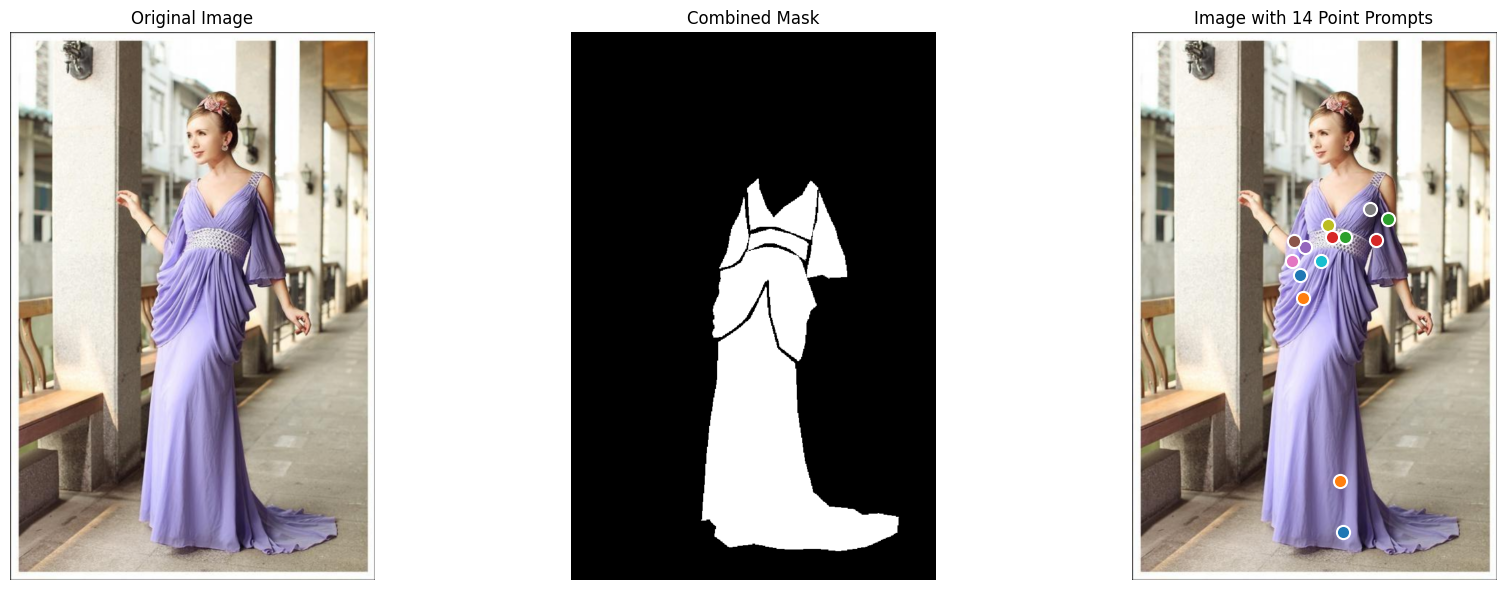

--------------------------------------------------
Visualizing for Index: 12, Filename: sample_2.jpg


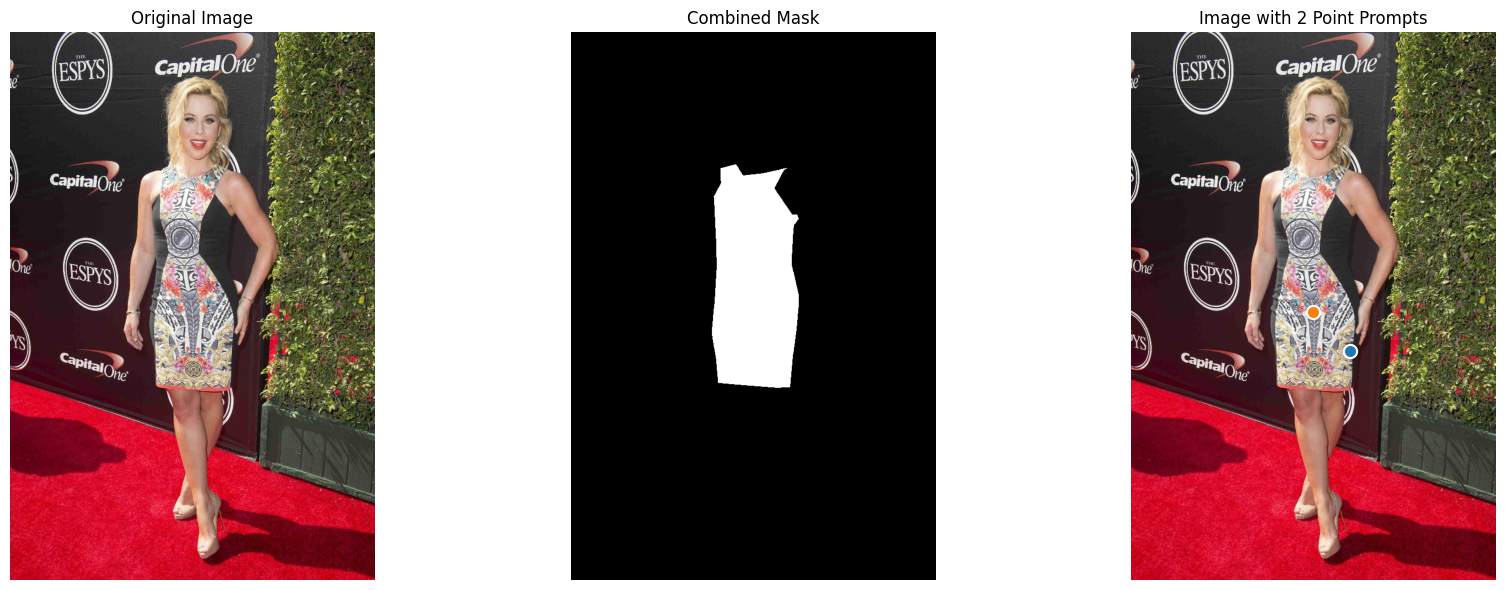

--------------------------------------------------
Visualizing for Index: 2, Filename: sample_12.jpg


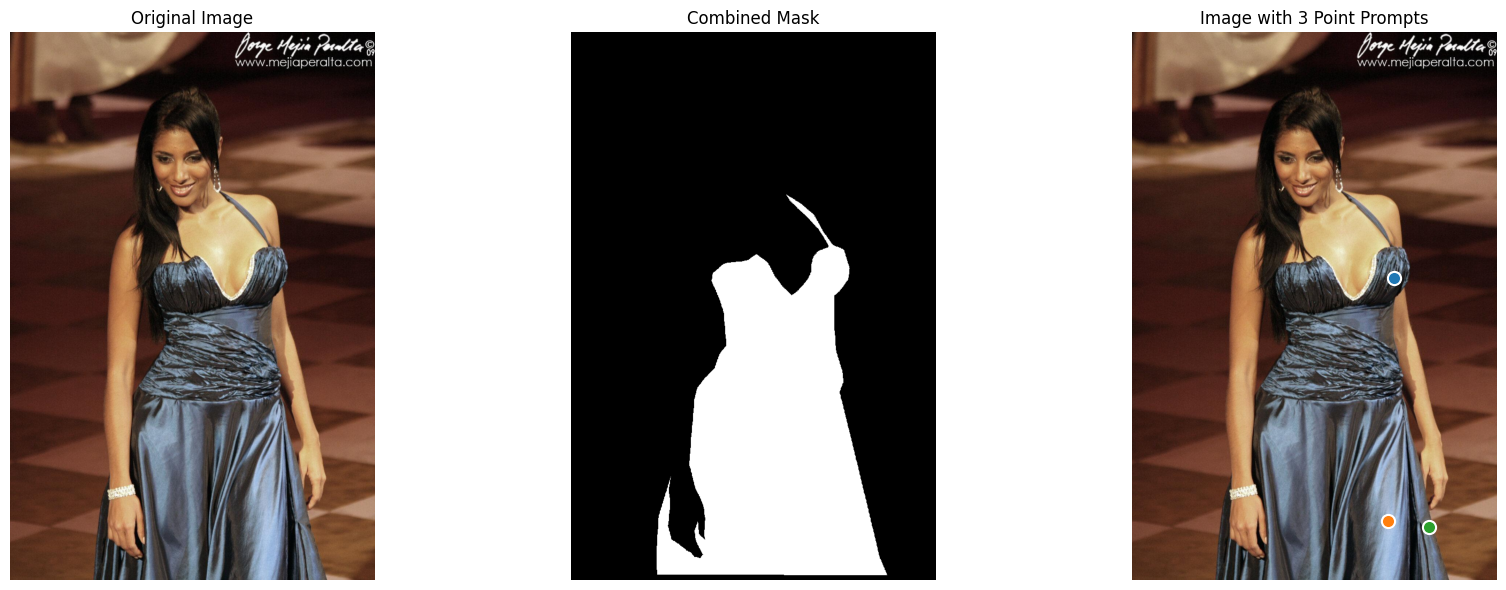

In [67]:
num_examples_to_show = 3

for _ in range(num_examples_to_show):
    random_idx = np.random.randint(len(hf_dataset))
    dataset_entry = hf_dataset[random_idx]
    filename = filenames[random_idx]
    
    print("-" * 50)
    print(f"Visualizing for Index: {random_idx}, Filename: {filename}")
    
    img,mask,pts = calculate_points_coco(dataset_entry, filename, coco)
    visualize_coco_points(img, mask, pts)